# Script to deconvolve the frequency response

/var/folders/lg/9twk84311llgwk38_815qyv80000gp/T/ipykernel_95328/484925412.py:12: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs_chirp, chirp = wav.read(chirp_filename)
/var/folders/lg/9twk84311llgwk38_815qyv80000gp/T/ipykernel_95328/484925412.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs_response, response = wav.read(response_filename)


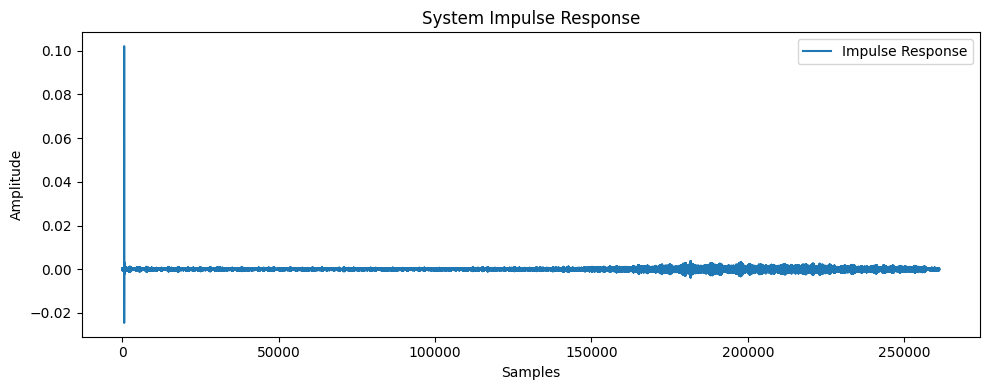

In [15]:
import numpy as np
import scipy.io.wavfile as wav
import scipy.signal as signal
import matplotlib.pyplot as plt

# Filenames for the chirp (input) and the system response (output)
mes_no = "13"
chirp_filename = f"recordings/sweep{mes_no}.wav"
response_filename = f"recordings/response{mes_no}.wav"

# Load the WAV files
fs_chirp, chirp = wav.read(chirp_filename)
fs_response, response = wav.read(response_filename)

# Ensure both files have the same sampling rate
if fs_chirp != fs_response:
    raise ValueError("Sampling rates do not match between the chirp and response files.")

# Optionally, convert to float if data is in integer format
chirp = chirp.astype(np.float32)
response = response.astype(np.float32)

# Zero pad signals to the same length (or next power-of-two for speed)
n = max(len(chirp), len(response))
chirp = np.pad(chirp, (0, n - len(chirp)))
response = np.pad(response, (0, n - len(response)))

# Compute the FFTs
chirp_fft = np.fft.fft(chirp)
response_fft = np.fft.fft(response)

# Regularization: add a small epsilon to avoid division by zero
epsilon = 1e-10
chirp_fft_regularized = chirp_fft + epsilon

# Frequency-domain deconvolution
H_fft = response_fft / chirp_fft_regularized

# Compute the impulse response using inverse FFT
impulse_response = np.fft.ifft(H_fft).real

# Save the impulse response to a new WAV file (scaling to int16 range if desired)
impulse_response_normalized = impulse_response / np.max(np.abs(impulse_response))
wav.write(f"deconv_responses/IR_{mes_no}.wav", fs_chirp, np.int16(impulse_response_normalized * 32767))

# Plot the impulse response
plt.figure(figsize=(10, 4))
plt.plot(impulse_response, label='Impulse Response')
plt.title('System Impulse Response')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

